In [1]:
import os
import numpy as np
import polars as pl
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from utils.plot_utils_case import agg_case_tpr_fpr

In [5]:
root = "../results_cp/orig_feat_level_16_white_balance_False_scale_0.25_trial_100_n_est_200_model_rf_alpha_min_0.02_alpha_max_0.2_step_alpha_0.02_dryrun_ Falsealpha0alpha1"
paths = glob(os.path.join(root, "*", "*"))

rows = []
for i in tqdm(range(len(paths))):
    path = paths[i]
    last_part = path.split("/")[-1]
    splits = last_part.split("_")
    r = int(splits[0])
    num_cv = int(splits[1])
    alpha0 = round(float(splits[3]), 3)
    alpha1 = round(float(splits[5]), 3)

    df = pl.read_csv(path)
    perf = agg_case_tpr_fpr(df)

    row = [r, num_cv, alpha0, alpha1] + perf
    rows.append(row)

100%|██████████| 40400/40400 [01:02<00:00, 647.68it/s]


In [6]:
total_perf_df = pl.DataFrame(
    rows, 
    schema=[
        "r", "cv", "alpha0", "alpha1", 
        "sensitivity", "specificity", "ambi"
    ], orient="row")

total_perf_df

r,cv,alpha0,alpha1,sensitivity,specificity,ambi
i64,i64,f64,f64,f64,f64,f64
52,0,0.1,0.16,0.5,1.0,0.272727
52,0,0.18,0.08,1.0,0.666667,0.454545
52,0,0.18,0.14,0.75,0.75,0.272727
52,0,0.04,0.12,1.0,1.0,0.545455
52,0,0.04,0.06,1.0,1.0,0.636364
…,…,…,…,…,…,…
80,1,0.04,0.1,1.0,1.0,0.727273
80,1,0.14,0.08,1.0,1.0,0.636364
80,1,0.02,0.1,0.0,1.0,0.909091


In [7]:
total_perf_df.filter(pl.col("alpha0") == 0.1).filter(pl.col("alpha1") == 0.1).filter(pl.col("r") == 50)

r,cv,alpha0,alpha1,sensitivity,specificity,ambi
i64,i64,f64,f64,f64,f64,f64
50,1,0.1,0.1,1.0,0.5,0.363636
50,3,0.1,0.1,1.0,0.0,0.7
50,2,0.1,0.1,0.666667,0.0,0.454545
50,0,0.1,0.1,1.0,0.0,0.727273


In [8]:
agg_perf = total_perf_df \
    .group_by("r", "alpha0", "alpha1") \
    .agg(
        pl.col("sensitivity").mean(),
        pl.col("specificity").mean(),
        pl.col("ambi").mean(),
        pl.len().alias("count")
    ) \
    .sort("alpha0", "alpha1", "r") \
    .group_by("alpha0", "alpha1") \
    .agg(
        pl.col("sensitivity").mean(),
        pl.col("specificity").mean(),
        pl.col("ambi").mean(),
        pl.col("count").sum().alias("total_count")
    ) \
    .sort("alpha0", "alpha1")

Text(50.722222222222214, 0.5, 'alpha0')

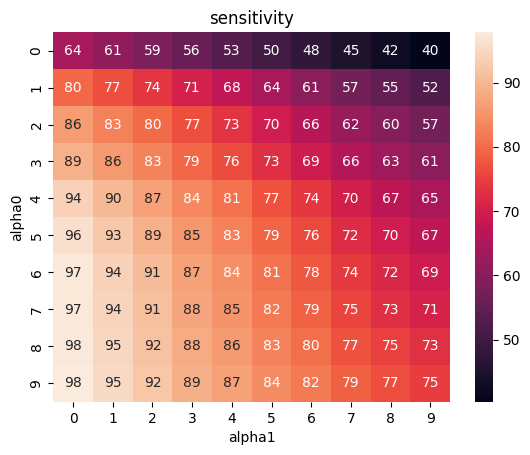

In [9]:
sns.heatmap(data=agg_perf.pivot(index="alpha0", on="alpha1", values="sensitivity").drop("alpha0").to_numpy() * 100, annot=True)
plt.title("sensitivity")
plt.xlabel("alpha1")
plt.ylabel("alpha0")

In [10]:
agg_perf.write_csv("tmp_agg_perf.csv")

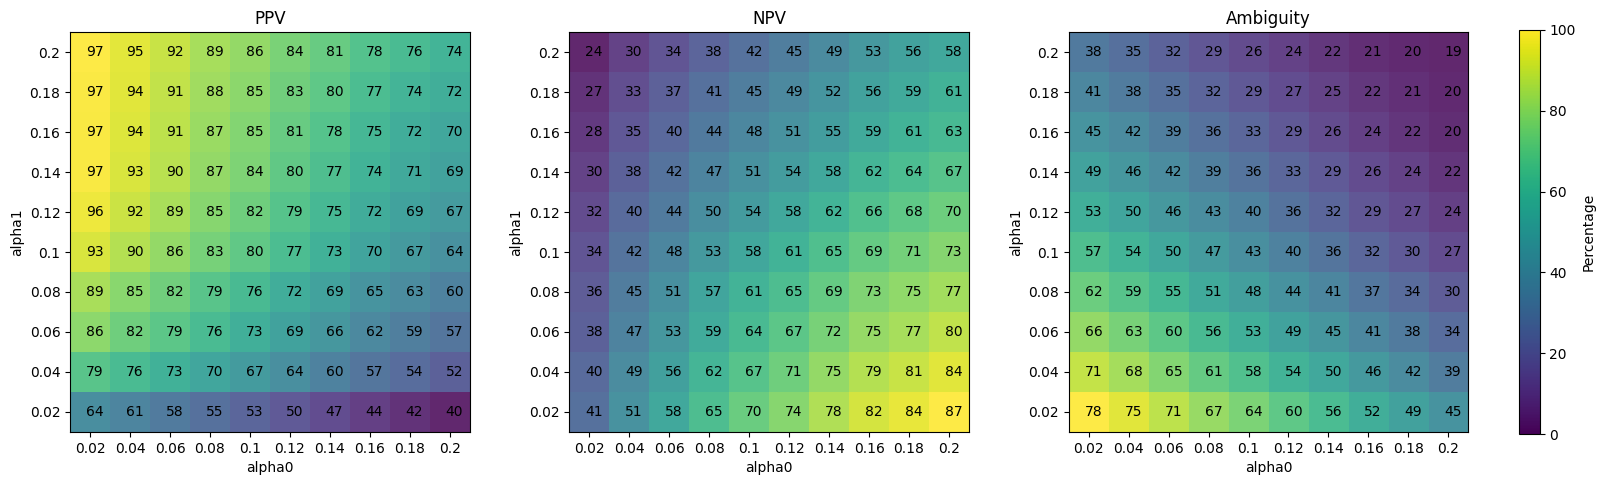

In [17]:
# Create a custom ScalarMappable for the colorbar
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=100)  # Set desired range here
sm = ScalarMappable(norm=norm, cmap='viridis')

fig, axs = plt.subplots(1, 3, figsize=(22, 15), gridspec_kw={'wspace': 0.25})

alpha = 0.85
xlabel = "alpha0"
ylabel = "alpha1"

feat = "sensitivity"
hm = agg_perf.pivot(index="alpha0", on="alpha1", values=feat).drop("alpha0").to_numpy()[::-1,:] * 100
im = axs[0].imshow(hm, cmap=sm.cmap, alpha=alpha)
for i in range(10):
    for j in range(10):
        value = int(hm[j, i])
        axs[0].text(i - 0.1, j + 0.1, value, c="black")
axs[0].set_xlabel(xlabel)
axs[0].set_ylabel(ylabel)
axs[0].set_xticks(ticks=np.arange(10), labels=[round(n, 2) for n in np.arange(0.02, 0.2 + 0.02, 0.02)])
axs[0].set_yticks(ticks=np.arange(10), labels=[round(n, 2) for n in np.arange(0.02, 0.2 + 0.02, 0.02)[::-1]])
axs[0].set_title("PPV")

########################################################################################################################

feat = "specificity"
hm = agg_perf.pivot(index="alpha0", on="alpha1", values=feat).drop("alpha0").to_numpy()[::-1,:] * 100
im = axs[1].imshow(hm, cmap=sm.cmap, alpha=alpha)
for i in range(10):
    for j in range(10):
        value = int(hm[j, i])
        axs[1].text(i - 0.1, j + 0.1, value, c="black")
axs[1].set_xlabel(xlabel)
axs[1].set_ylabel(ylabel)
axs[1].set_xticks(ticks=np.arange(10), labels=[round(n, 2) for n in np.arange(0.02, 0.2 + 0.02, 0.02)])
axs[1].set_yticks(ticks=np.arange(10), labels=[round(n, 2) for n in np.arange(0.02, 0.2 + 0.02, 0.02)[::-1]])
axs[1].set_title("NPV")
########################################################################################################################

feat = "ambi"
hm = agg_perf.pivot(index="alpha0", on="alpha1", values=feat).drop("alpha0").to_numpy()[::-1,:] * 100
im = axs[2].imshow(hm, cmap=sm.cmap, alpha=alpha)
for i in range(10):
    for j in range(10):
        value = int(hm[j, i])
        axs[2].text(i - 0.1, j + 0.1, value, c="black")
axs[2].set_xlabel(xlabel)
axs[2].set_ylabel(ylabel)
axs[2].set_xticks(ticks=np.arange(10), labels=[round(n, 2) for n in np.arange(0.02, 0.2 + 0.02, 0.02)])
axs[2].set_yticks(ticks=np.arange(10), labels=[round(n, 2) for n in np.arange(0.02, 0.2 + 0.02, 0.02)[::-1]])
axs[2].set_title("Ambiguity")


# Create a colorbar on the right with the desired range
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), shrink=0.35, pad=0.03)
cbar.set_label('Percentage')

fig.savefig("perf_alpha0alpha1.png", dpi=300, bbox_inches="tight")

In [12]:
# create snake plot
# 1) start from a0 = 0.025 and a1 = 0.25
# 2) move in the direction where both a0 and a1 are increased
# 3) stop when we can't move
# 4) in the cell that we stop, moving to either direction will enter the trade-off region